# Nanoprism model with orientational averaging of the scattering intensity: fitting on experimental data

This notebook demonstrates the use of pure Python models to perform orientational averaging of the scattering intensity.

Two main models exist: `nanoprisms_lebedev.py` and `nanoprisms_fibonacci.py`.

The `nanoprisms_fibonacci.py` method is the best compromise between accuracy and computational time (see the nanoprisms_quadratures_comparison notebook). The `nanoprisms_lebedev.py` model has a higher computational time but is still acceptable.

*NB: A Gauss-Legendre model also exists (`nanoprisms_gausslegendre.py`), however, it has the highest computational time. We do not recommend using it (except for comparison purposes).*

===================================================================================================================================================

# Installation Instructions

## Installation of the Nanoprism Models
To use the nanoprism quadrature models, copy the files you are interested in:
`nanoprisms_lebedev.py`, `nanoprisms_fibonacci.py`, and
`nanoprisms_gausslegendre.py` into your SASView user models directory.

- These files are typically located at:
    `C:\Users\Administrateur\AppData\Local\Programs\Python\Python310\Lib\site-packages\sasmodels\models`

- For use with the SASView GUI, place them in your user plugin folder:
    `C:\Users\Administrateur\.sasview\plugin_models`

## Installation of the prismformfactors Library
The models require the `prismformfactors` library, which can be installed from:
- https://github.com/jules-marcone/prismformfactors

If you are using a global Python environment on Windows, the library should be located at:
`C:\Users\Administrateur\AppData\Local\Programs\Python\Python310\Lib\site-packages\prismformfactors`

Before using the model with the SASView GUI, copy the library to:
`C:\SasView-6.0.0\prismformfactors`

## Installation for the Three Quadrature Models
For the Fibonacci and Gauss-Legendre quadrature models, no additional libraries are required beyond standard Python and NumPy (included with SASView).

For the Lebedev quadrature model, you must install the `pyLebedev` library:

- Install using pip:  
    `pip install pylebedev`
- More information: https://pypi.org/project/pylebedev/

If you are using a global Python environment on Windows, the library should be located at:
`C:\Users\Administrateur\AppData\Local\Programs\Python\Python310\Lib\site-packages\pylebedev`

Copy the library to:
`C:\SasView-6.0.0\pylebedev` for use with SASView GUI.

===================================================================================================================================================




# Beginning of code

Import all the packages
* need installation of sasmodels, sasdata, bumps in your python environnement (see installation notebook in how-to-start)

In [1]:

%matplotlib widget
import numpy as np
# import sasmodels
import sasmodels
import sasmodels.core
import sasmodels.bumps_model
from sasmodels.core import load_model
import sasmodels.data

import bumps
import bumps.fitters
import bumps.names
import bumps.fitproblem

import os
import matplotlib.pyplot as plt

from nanoprisms_fibonacci import *
from nanoprisms_lebedev import *
from nanoprisms_gausslegendre import *


### Load 1D data
* e6_output_full.dat is data from JAC nanoprisms paper
* load the data from an example .dat file into a numpy array
* transform the numpy array into a suitable 1D data set using `sasmodels.data.Data1D`
* possiblity to reduce the number of data points by slicing

2373
238


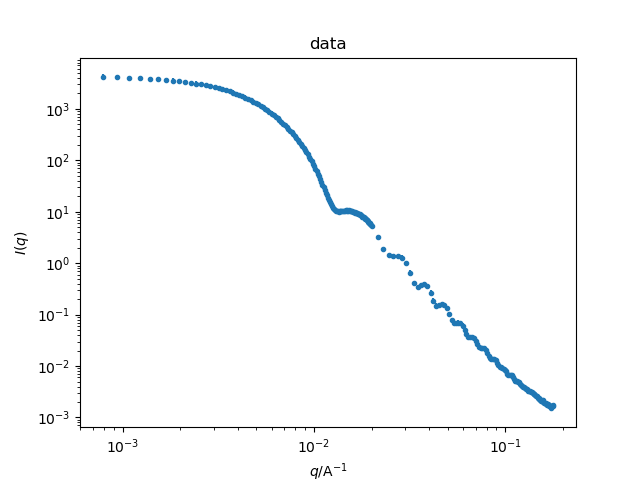

In [2]:
filename='../test_data/e6_output_full.dat' # data from JAC nanoprisms paper 
data_np = np.loadtxt(filename, skiprows=40)

number_of_data=data_np.shape[0] #total number of data points in the file
print(number_of_data)

slicing_step=10 # step of slicing 

# new error bars: 10 % of intensity values
coeff=0.1
#data = sasmodels.data.Data1D(x=data_np[:,0], y=data_np[:,1], dy=data_np[:,2])
data = sasmodels.data.Data1D(x=data_np[0:number_of_data:slicing_step,0], 
                             y=data_np[0:number_of_data:slicing_step,1], 
                             dy=coeff*data_np[0:number_of_data:slicing_step,1])

number_of_data_new=data.x.shape[0]
print(number_of_data_new)

sasmodels.data.plot_data(data)

Save the data file after applying slicing and modifying error bars

In [3]:
newfilename='../test_data/e6_output_new.dat' # data after slicing and error bars correction 

with open(newfilename, "w") as f:
    f.write("raw data file is: e6_output_full.dat\n")
    f.write("number of data points: \t"+str(number_of_data_new)+"\n")

with open(newfilename, "a") as fa:
    for i in range(0,number_of_data_new):
        line_to_write=str(data.x[i])+"\t"+str(data.y[i])+"\t"+str(data.dy[i])+"\n"
        fa.write(line_to_write)


## Use the sasview models: 

### Fit with the model 
* create the computation `kernel` selecting the `nanoprisms_lebedev.py`, `nanoprisms_fibonacci.py` or `nanoprisms_gausslegendre.py` models
* create the `modelfit` interfaced with bump module
* create the `experiment`, containing both data and model

In [4]:
sasmodels.core.list_models()

['adsorbed_layer',
 'barbell',
 'bcc_paracrystal',
 'be_polyelectrolyte',
 'binary_hard_sphere',
 'broad_peak',
 'capped_cylinder',
 'core_multi_shell',
 'core_shell_bicelle',
 'core_shell_bicelle_elliptical',
 'core_shell_bicelle_elliptical_belt_rough',
 'core_shell_cylinder',
 'core_shell_ellipsoid',
 'core_shell_parallelepiped',
 'core_shell_sphere',
 'correlation_length',
 'cylinder',
 'dab',
 'ellipsoid',
 'elliptical_cylinder',
 'fcc_paracrystal',
 'flexible_cylinder',
 'flexible_cylinder_elliptical',
 'fractal',
 'fractal_core_shell',
 'fuzzy_sphere',
 'gauss_lorentz_gel',
 'gaussian_peak',
 'gel_fit',
 'guinier',
 'guinier_porod',
 'hardsphere',
 'hayter_msa',
 'hollow_cylinder',
 'hollow_rectangular_prism',
 'hollow_rectangular_prism_thin_walls',
 'lamellar',
 'lamellar_hg',
 'lamellar_hg_stack_caille',
 'lamellar_stack_caille',
 'lamellar_stack_paracrystal',
 'line',
 'linear_pearls',
 'lorentz',
 'mass_fractal',
 'mass_surface_fractal',
 'micromagnetic_FF_3D',
 'mono_gauss_c

### Use one of the three quadratures models:
#### Parameters for the nanoprism
- **n_sides**: the number of sides of the cross section of the nanoprism
- **R_ave**: the avarage radius of the nanoprism in Angstrom
- **L**: the length of the nanoprism in Angstrom


#### Parameters for the quadratures
- Fibonnaci: **npoints_fibonnaci**, being the total of points on the unit sphere for integration
- Lebedev: **norder_index**, being the index of the order of the polynom list : orderlist=[3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 35, 41, 47, 53, 59, 65, 71, 77, 83, 89, 95, 101, 107, 113, 119, 125, 131]
- Gauss-Legendre: **npoints_gauss**, being the number ofpoints for each angle, the total number of points being  npoints_gauss**2

To choose the number of points of the quadrature, please refer to the `nanoprisms_quadratures` noteboook that compares the efficiecy of each method depending on the number of total points on the unit sphere.


### Let's use the Fibonacci quadrature with 300 points on the unit sphere

Execution time Fibonacci with 300.0 points: 0.0385 seconds
Execution time Fibonacci with 300.0 points: 0.0360 seconds
Execution time Fibonacci with 300.0 points: 0.0377 seconds
Execution time Fibonacci with 300.0 points: 0.0313 seconds
Execution time Fibonacci with 300.0 points: 0.0346 seconds
Execution time Fibonacci with 300.0 points: 0.0311 seconds
Execution time Fibonacci with 300.0 points: 0.0336 seconds
Execution time Fibonacci with 300.0 points: 0.0345 seconds
Execution time Fibonacci with 300.0 points: 0.0318 seconds
Execution time Fibonacci with 300.0 points: 0.0317 seconds


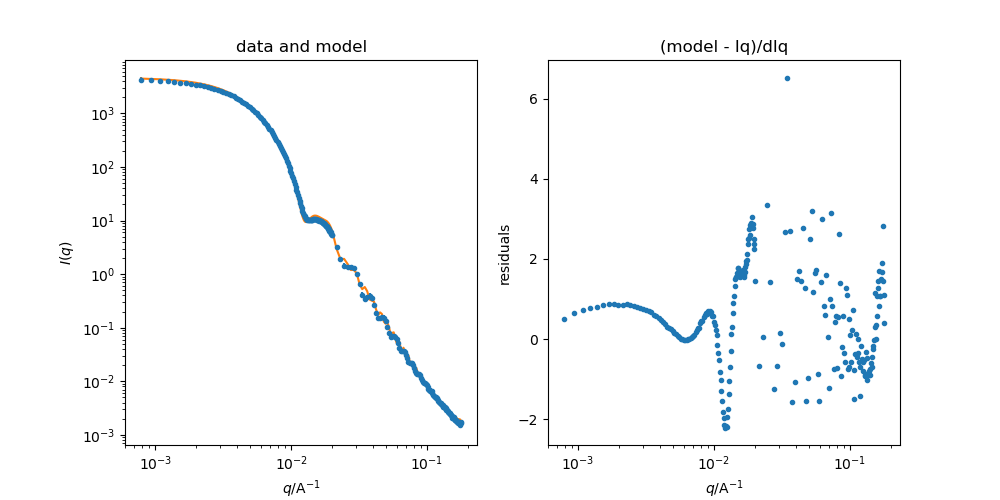

In [13]:
kernel = sasmodels.core.load_model("nanoprisms_fibonacci")  # choose here the model: nanoprisms_lebedev, nanoprisms_fibonacci, nanoprisms_gausslegendre
params = {
    "background": 0.001,
    "scale": 0.3e-17,
    "n_sides" : 5,
    "R_ave": 300,
    "L":1170,
    "npoints_fibonacci": 300,
    "R_ave_pd_type": 'gaussian', #type of polydispersity function
    "R_ave_pd": 0.08, #polydispersity
    "R_ave_pd_n": 10, #number of steps in polydispersity
    "R_ave_pd_nsigma": 3, #range as multiple of sigma
}


modelfit = sasmodels.bumps_model.Model(kernel, **params)
experiment = sasmodels.bumps_model.Experiment(data=data, model=modelfit)

plt.figure(figsize=(10,5))
experiment.plot()

Execution time Fibonacci with 300.0 points: 0.0368 seconds
Execution time Fibonacci with 300.0 points: 0.0326 seconds
Execution time Fibonacci with 300.0 points: 0.0339 seconds
Execution time Fibonacci with 300.0 points: 0.0312 seconds
Execution time Fibonacci with 300.0 points: 0.0304 seconds
Execution time Fibonacci with 300.0 points: 0.0310 seconds
Execution time Fibonacci with 300.0 points: 0.0297 seconds
Execution time Fibonacci with 300.0 points: 0.0311 seconds
Execution time Fibonacci with 300.0 points: 0.0421 seconds
Execution time Fibonacci with 300.0 points: 0.0359 seconds
step 1 cost 1.961(20)
                                       L .|........       1170 in [1100, 1500]
                                   R_ave ....|.....        300 in [250, 350]
                              background ....|.....      0.001 in [0.0005, 0.0015]
                                   scale ..|.......      3e-18 in [2e-18, 6e-18]
Execution time Fibonacci with 300.0 points: 0.0314 seconds
Execution

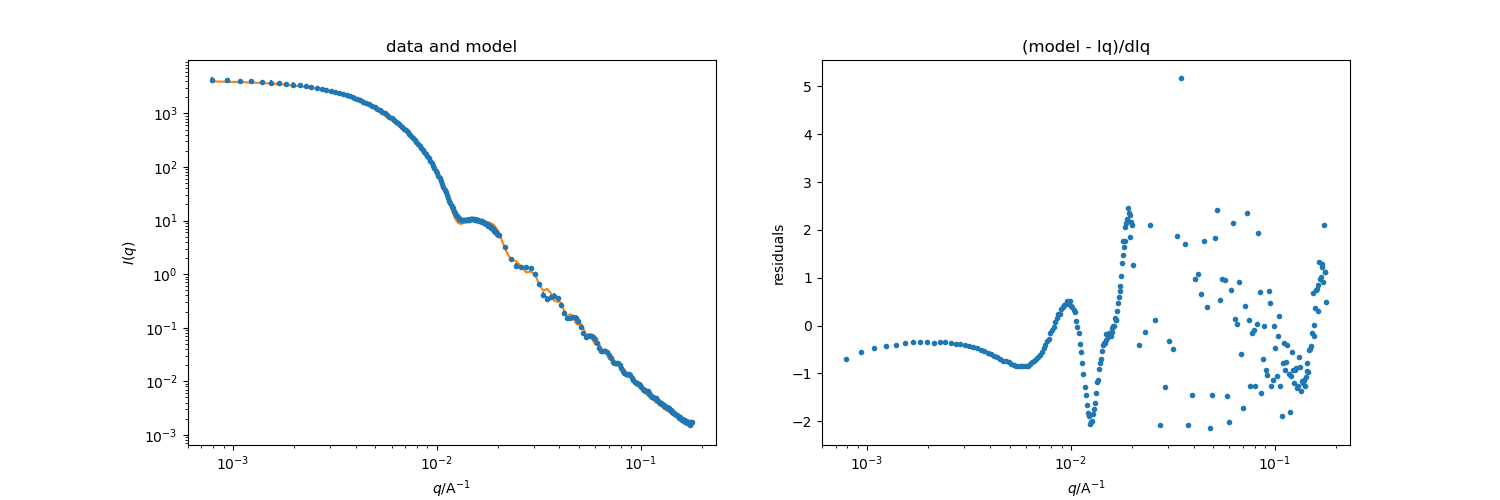

In [14]:
#list of the fiting parameters with their fiting range
modelfit.scale.range(0.2e-17, 0.6e-17)
modelfit.background.range(0.0005, 0.0015)
modelfit.R_ave.range(250, 350)
modelfit.L.range(1100,1500)
#modelfit.R_ave_pd.range(0.04,0.08)

problem = bumps.fitproblem.FitProblem(experiment)

results = bumps.fitters.fit(problem, 
                            method='lm', 
                            steps=20, 
                            ftol=1.5e-06, 
                            xtol=1.5e-06, 
                            verbose=True)

plt.figure(figsize=(15,5))
problem.plot()
print(problem.summarize())

The current value of all parameters can always be called using `model.state()`:

In [16]:
modelfit.state()

{'scale': 2.8778436656816076e-18,
 'background': 0.000998976724363847,
 'sld': 126.0,
 'sld_solvent': 9.4,
 'n_sides': 5.0,
 'R_ave': 294.04461985252686,
 'R_ave_pd': 0.08,
 'R_ave_pd_n': 10.0,
 'R_ave_pd_nsigma': 3.0,
 'L': 1170.6084716192743,
 'L_pd': 0.0,
 'L_pd_n': 35.0,
 'L_pd_nsigma': 3.0,
 'npoints_fibonacci': 300.0,
 'up_frac_i': 0.0,
 'up_frac_f': 0.0,
 'up_theta': 90.0,
 'up_phi': 0.0,
 'sld_M0': 0.0,
 'sld_mtheta': 0.0,
 'sld_mphi': 0.0,
 'sld_solvent_M0': 0.0,
 'sld_solvent_mtheta': 0.0,
 'sld_solvent_mphi': 0.0,
 'R_ave_pd_type': 'gaussian',
 'L_pd_type': 'gaussian'}

In [17]:
print(problem.summarize())

                                       L .|........    1170.61 in [1100, 1500]
                                   R_ave ....|.....    294.045 in [250, 350]
                              background ....|..... 0.000998977 in [0.0005, 0.0015]
                                   scale ..|....... 2.87784e-18 in [2e-18, 6e-18]


In [18]:
results.x

array([1.17060847e+03, 2.94044620e+02, 9.98976724e-04, 2.87784367e-18])

In [19]:
problem.labels()

['L', 'R_ave', 'background', 'scale']

In [20]:
problem.fitness.model.state()

c:\Users\saram\anaconda3\envs\rods\lib\site-packages\bumps\fitproblem.py:305: UserWarning: Deprecated: use of problem.fitness will be removed at some point
  warnings.warn("Deprecated: use of problem.fitness will be removed at some point")


{'scale': 2.8778436656816076e-18,
 'background': 0.000998976724363847,
 'sld': 126.0,
 'sld_solvent': 9.4,
 'n_sides': 5.0,
 'R_ave': 294.04461985252686,
 'R_ave_pd': 0.08,
 'R_ave_pd_n': 10.0,
 'R_ave_pd_nsigma': 3.0,
 'L': 1170.6084716192743,
 'L_pd': 0.0,
 'L_pd_n': 35.0,
 'L_pd_nsigma': 3.0,
 'npoints_fibonacci': 300.0,
 'up_frac_i': 0.0,
 'up_frac_f': 0.0,
 'up_theta': 90.0,
 'up_phi': 0.0,
 'sld_M0': 0.0,
 'sld_mtheta': 0.0,
 'sld_mphi': 0.0,
 'sld_solvent_M0': 0.0,
 'sld_solvent_mtheta': 0.0,
 'sld_solvent_mphi': 0.0,
 'R_ave_pd_type': 'gaussian',
 'L_pd_type': 'gaussian'}